In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/CV project/

/content/drive/MyDrive/CV project


In [ ]:
#@title

import sys
import os
os.environ["HDF5_USE_FILE_LOCKING"]='FALSE'
import h5py
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import torch
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from display import get_cmap, vil_cmap, vis_cmap, ir_cmap, c09_cmap
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from model import SmaAt_UNet
import cv2
import torchvision.transforms as T
from torchvision import models, datasets, transforms
from tqdm import tqdm
from io import BytesIO
import copy
import torch.nn as nn
# importing libraries to implement style-transfer

from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sys.path.append('/content/drive/MyDrive/CV project/')

from matplotlib import cm
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.patches as patches

In [ ]:
#@title
import torch
from torch import nn
import torch.nn.functional as F


# Taken from https://discuss.pytorch.org/t/is-there-any-layer-like-tensorflows-space-to-depth-function/3487/14
class DepthToSpace(nn.Module):

    def __init__(self, block_size):
        super().__init__()
        self.bs = block_size

    def forward(self, x):
        N, C, H, W = x.size()
        x = x.view(N, self.bs, self.bs, C // (self.bs ** 2), H, W)  # (N, bs, bs, C//bs^2, H, W)
        x = x.permute(0, 3, 4, 1, 5, 2).contiguous()  # (N, C//bs^2, H, bs, W, bs)
        x = x.view(N, C // (self.bs ** 2), H * self.bs, W * self.bs)  # (N, C//bs^2, H * bs, W * bs)
        return x


class SpaceToDepth(nn.Module):
    # Expects the following shape: Batch, Channel, Height, Width
    def __init__(self, block_size):
        super().__init__()
        self.bs = block_size

    def forward(self, x):
        N, C, H, W = x.size()
        x = x.view(N, C, H // self.bs, self.bs, W // self.bs, self.bs)  # (N, C, H//bs, bs, W//bs, bs)
        x = x.permute(0, 3, 5, 1, 2, 4).contiguous()  # (N, bs, bs, C, H//bs, W//bs)
        x = x.view(N, C * (self.bs ** 2), H // self.bs, W // self.bs)  # (N, C*bs^2, H//bs, W//bs)
        return x


class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, output_channels, kernel_size, padding=0, kernels_per_layer=1):
        super(DepthwiseSeparableConv, self).__init__()
        # In Tensorflow DepthwiseConv2D has depth_multiplier instead of kernels_per_layer
        self.depthwise = nn.Conv2d(in_channels, in_channels * kernels_per_layer, kernel_size=kernel_size, padding=padding,
                                   groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels * kernels_per_layer, output_channels, kernel_size=1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x


class DoubleDense(nn.Module):
    def __init__(self, in_channels, hidden_neurons, output_channels):
        super(DoubleDense, self).__init__()
        self.dense1 = nn.Linear(in_channels, out_features=hidden_neurons)
        self.dense2 = nn.Linear(in_features=hidden_neurons, out_features=hidden_neurons // 2)
        self.dense3 = nn.Linear(in_features=hidden_neurons // 2, out_features=output_channels)

    def forward(self, x):
        out = F.relu(self.dense1(x.view(x.size(0), -1)))
        out = F.relu(self.dense2(out))
        out = self.dense3(out)
        return out


class DoubleDSConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_ds_conv = nn.Sequential(
            DepthwiseSeparableConv(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_ds_conv(x)


class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)


class ChannelAttention(nn.Module):
    def __init__(self, input_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.input_channels = input_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        #  https://github.com/luuuyi/CBAM.PyTorch/blob/master/model/resnet_cbam.py
        #  uses Convolutions instead of Linear
        self.MLP = nn.Sequential(
            Flatten(),
            nn.Linear(input_channels, input_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(input_channels // reduction_ratio, input_channels)
        )

    def forward(self, x):
        # Take the input and apply average and max pooling
        avg_values = self.avg_pool(x)
        max_values = self.max_pool(x)
        out = self.MLP(avg_values) + self.MLP(max_values)
        scale = x * torch.sigmoid(out).unsqueeze(2).unsqueeze(3).expand_as(x)
        return scale


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(1)

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(out)
        out = self.bn(out)
        scale = x * torch.sigmoid(out)
        return scale


class CBAM(nn.Module):
    def __init__(self, input_channels, reduction_ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_att = ChannelAttention(input_channels, reduction_ratio=reduction_ratio)
        self.spatial_att = SpatialAttention(kernel_size=kernel_size)

    def forward(self, x):
        out = self.channel_att(x)
        out = self.spatial_att(out)
        return out





""" Parts of the U-Net model """
# Base model taken from: https://github.com/milesial/Pytorch-UNet
import torch
import torch.nn as nn
import torch.nn.functional as F
#from models.layers import DepthwiseSeparableConv


class DoubleConvDS(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None, kernels_per_layer=1):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            DepthwiseSeparableConv(in_channels, mid_channels, kernel_size=3, kernels_per_layer=kernels_per_layer, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(mid_channels, out_channels, kernel_size=3, kernels_per_layer=kernels_per_layer, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class DownDS(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels, kernels_per_layer=1):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConvDS(in_channels, out_channels, kernels_per_layer=kernels_per_layer)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class UpDS(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True, kernels_per_layer=1):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConvDS(in_channels, out_channels, in_channels // 2, kernels_per_layer=kernels_per_layer)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConvDS(in_channels, out_channels, kernels_per_layer=kernels_per_layer)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


from torch import nn
#from models.unet_parts import OutConv
#from models.unet_parts_depthwise_separable import DoubleConvDS, UpDS, DownDS
#from models.layers import CBAM


class SmaAt_UNet(nn.Module):
    def __init__(self, n_channels, n_classes, kernels_per_layer=2, bilinear=True, reduction_ratio=16):
        super(SmaAt_UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        kernels_per_layer = kernels_per_layer
        self.bilinear = bilinear
        reduction_ratio = reduction_ratio

        self.inc = DoubleConvDS(self.n_channels, 64, kernels_per_layer=kernels_per_layer)
        self.cbam1 = CBAM(64, reduction_ratio=reduction_ratio)
        self.down1 = DownDS(64, 128, kernels_per_layer=kernels_per_layer)
        self.cbam2 = CBAM(128, reduction_ratio=reduction_ratio)
        self.down2 = DownDS(128, 256, kernels_per_layer=kernels_per_layer)
        self.cbam3 = CBAM(256, reduction_ratio=reduction_ratio)
        self.down3 = DownDS(256, 512, kernels_per_layer=kernels_per_layer)
        self.cbam4 = CBAM(512, reduction_ratio=reduction_ratio)
        factor = 2 if self.bilinear else 1
        self.down4 = DownDS(512, 1024 // factor, kernels_per_layer=kernels_per_layer)
        self.cbam5 = CBAM(1024 // factor, reduction_ratio=reduction_ratio)
        self.up1 = UpDS(1024, 512 // factor, self.bilinear, kernels_per_layer=kernels_per_layer)
        self.up2 = UpDS(512, 256 // factor, self.bilinear, kernels_per_layer=kernels_per_layer)
        self.up3 = UpDS(256, 128 // factor, self.bilinear, kernels_per_layer=kernels_per_layer)
        self.up4 = UpDS(128, 64, self.bilinear, kernels_per_layer=kernels_per_layer)

        self.outc = OutConv(64, self.n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x1Att = self.cbam1(x1)
        x2 = self.down1(x1)
        x2Att = self.cbam2(x2)
        x3 = self.down2(x2)
        x3Att = self.cbam3(x3)
        x4 = self.down3(x3)
        x4Att = self.cbam4(x4)
        x5 = self.down4(x4)
        x5Att = self.cbam5(x5)
        x = self.up1(x5Att, x4Att)
        x = self.up2(x, x3Att)
        x = self.up3(x, x2Att)
        x = self.up4(x, x1Att)
        logits = self.outc(x)
        return logits

## Read in Data

In [ ]:
#@title

## Load data
data_path = 'data/'
DEST_TRAIN_FILE= os.path.join(data_path,'nowcast_training_000.h5')
DEST_TEST_FILE= os.path.join(data_path, 'nowcast_testing_000.h5')

In [ ]:
# Control how many samples are read.   Set to -1 to read all 5000 samples.
N_TRAIN=1000
TRAIN_VAL_FRAC=0.8
N_TEST=10

In [ ]:
#@title
# Loading data takes a few minutes
with h5py.File(DEST_TRAIN_FILE,'r') as hf:
    Nr = N_TRAIN if N_TRAIN>=0 else hf['IN_vil'].shape[0]
    X_train = hf['IN_vil'][:Nr]
    Y_train = hf['OUT_vil'][:Nr]
    X_train,X_val=np.split(X_train,[int(TRAIN_VAL_FRAC*Nr)])
    Y_train,Y_val=np.split(Y_train,[int(TRAIN_VAL_FRAC*Nr)])
        
# with h5py.File(DEST_TEST_FILE,'r') as hf:
#     Nr = N_TEST if N_TEST>=0 else hf['IN_vil'].shape[0]
#     X_test = hf['IN_vil'][:Nr]
#     Y_test = hf['OUT_vil'][:Nr]

In [ ]:
train_data = np.concatenate((X_train,Y_train),axis=3)
del X_train
del Y_train
val_data = np.concatenate((X_val,Y_val),axis=3)
del X_val
del Y_val
#test_data = np.concatenate((X_test,Y_test),axis=3)

In [ ]:
# del X_test
# del Y_test

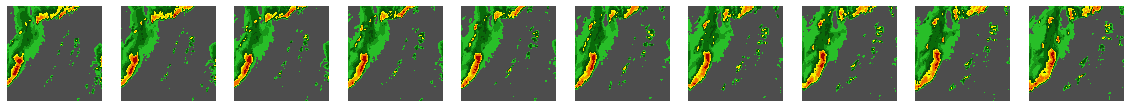

In [ ]:
img_index=5
cmap,norm,vmin,vmax=get_cmap('vil')
fig,axs=plt.subplots(1,10,figsize=(20,8))
for i in range(10):
    axs[i].imshow(train_data[img_index,:,:,i],origin='lower',cmap=cmap,norm=norm,vmin=vmin,vmax=vmax) 
    axs[i].set_axis_off()

In [ ]:
## Send data to the GPU
train_data = torch.tensor(train_data)#.to(device)
val_data = torch.tensor(val_data)#.to(device)
#test_data = torch.tensor(test_data)#.to(device)

In [ ]:
#@title
## See shapes of training data
print("Training data shape is: ", train_data.shape) ## (n_egs, height, width, num_frames)
#print("Testing data shape is: ", test_data.shape) ## (n_egs, height, width, num_frames)
print("Valid data shape is: ", val_data.shape) ## (n_egs, height, width, num_frames)

Training data shape is:  torch.Size([800, 384, 384, 25])
Valid data shape is:  torch.Size([200, 384, 384, 25])


### Define blur and downsample function that takes ALL of train, val, and test data and gives blurred and downsampled versions of it 

In [ ]:
## We need to use downsampled data for training our model because colab suxx

## input shape is = (n_egs, height, width, num_frames). For now height = width --> Is a torch tensor
## op_size is the height/width we would want our downsampled output to have
## sigma: The variance of the gaussian blur that we will apply to the images before downsampling


def blur_downsample(input, op_size, kernel_size=(5,5) ,sigma=(1,1)):
  
  n_egs, ip_h, ip_w, num_frames = input.shape 
  op = torch.zeros((n_egs, op_size, op_size, num_frames))

  # Define the blur transformation
  blur_transform = T.GaussianBlur(kernel_size=kernel_size, sigma=sigma)
  ds_transform = T.Resize((op_size,op_size))

  for eg in range(n_egs):
    cur_seq = input[eg,:,:,:]
    for frame_num in range(num_frames):
      cur_img = cur_seq[:,:,frame_num]

      ## First apply Gaussian blur to this image 
      cur_img_blrd = blur_transform(cur_img[None,:,:])
      
      ## Now downsample this blurred image
      cur_img_ds = ds_transform(cur_img_blrd)[0]
      op[eg,:,:,frame_num] = cur_img_ds 
  
  return op

In [ ]:
train_data = blur_downsample(train_data.float(), 192)
val_data = blur_downsample(val_data.float(), 192)
#test_data = blur_downsample(test_data.float(), 192)

In [ ]:
#@title
## See shapes of training data
print("Training data shape is: ", train_data.shape) ## (n_egs, height, width, num_frames)
#print("Testing data shape is: ", test_data.shape) ## (n_egs, height, width, num_frames)
print("Valid data shape is: ", val_data.shape) ## (n_egs, height, width, num_frames)

Training data shape is:  torch.Size([800, 192, 192, 25])
Valid data shape is:  torch.Size([200, 192, 192, 25])


In [ ]:
## Save downsampled training data of 1000 examples so that I don't have to read it in again!
torch.save(train_data, 'train_tensor_1000.pt')
torch.save(val_data, 'val_tensor_1000.pt')

In [ ]:
train_data = torch.load('train_tensor_1000.pt')
val_data = torch.load('val_tensor_1000.pt')

In [ ]:
data = torch.load('train_1000_96_96_25.pt')

In [ ]:
train_data = data[:720,:,:,:]
val_data = data[720:900,:,:,:]

In [ ]:
train_data.shape

torch.Size([720, 96, 96, 25])

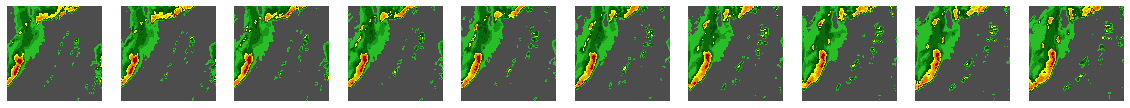

In [ ]:
img_index=5
cmap,norm,vmin,vmax=get_cmap('vil')
fig,axs=plt.subplots(1,10,figsize=(20,8))
for i in range(10):
    axs[i].imshow(train_data[img_index,:,:,i],origin='lower',cmap=cmap,norm=norm,vmin=vmin,vmax=vmax) 
    axs[i].set_axis_off()

Transpose all data so that shape now is (num_egs, num_frames, height, width) as that is the ordering with which the U-net architecture will read in the data

In [ ]:
#@title
train_data = torch.transpose(train_data, 2, 3)
#train = torch.transpose(train, 1, 2).to(device).float()
train_data = torch.transpose(train_data, 1, 2).float()
# train_X = train_data[:,:13,:,:]
# train_Y = train_data[:,13:,:,:]

#test_data = torch.transpose(test_data, 2, 3)

#test = torch.transpose(test, 1, 2).to(device).float()


#test_data = torch.transpose(test_data, 1, 2).float()
# test_X = test_data[:,:13,:,:]
# test_Y = test_data[:,13:,:,:]

val_data = torch.transpose(val_data, 2, 3)
#val = torch.transpose(val, 1, 2).to(device).float()
val_data = torch.transpose(val_data, 1, 2).float()
# val_X = val_data[:,:13,:,:]
# val_Y = val_data[:,13:,:,:]

print("Training data shape is: ", train_data.shape) ## (n_egs, num_frames, height, width)
#print("Testing data shape is: ", test_data.shape) ## (n_egs, num_frames, height, width)
print("Valid data shape is: ", val_data.shape) ## (n_egs, num_frames, height, width)

Training data shape is:  torch.Size([720, 25, 96, 96])
Valid data shape is:  torch.Size([180, 25, 96, 96])


## Normalize training data

In [ ]:
norm_ = {'scale':47.54,'shift':33.44}
train_data = (train_data - norm_['shift'])/norm_['scale']
val_data = (val_data - norm_['shift'])/norm_['scale']

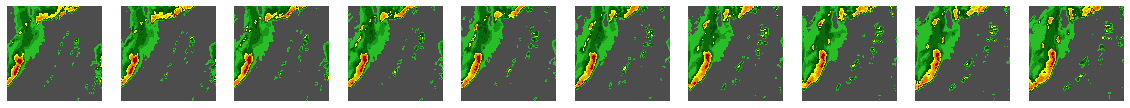

In [ ]:
norm_ = {'scale':47.54,'shift':33.44}
img_index=5
cmap,norm,vmin,vmax=get_cmap('vil')
fig,axs=plt.subplots(1,10,figsize=(20,8))
for i in range(10):
    axs[i].imshow((train_data[img_index,i,:,:]*norm_['scale']+norm_['shift']),origin='lower',cmap=cmap,norm=norm,vmin=vmin,vmax=vmax) 
    axs[i].set_axis_off()

### Create SEVIR Dataset class for more efficient reading in of data

In [ ]:
class SEVIR_Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, full_data):  # Full data shape is (n_egs, num_frames, height, width), includes X and Y
        'Initialization'
        self.X_egs = full_data[:,:13,:,:]
        self.Y_egs = full_data[:,13:,:,:]

  def __len__(self):
        'Denotes the total number of samples'
        return self.X_egs.shape[0]

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample

        # Load data and get label
        X = self.X_egs[index,:,:,:]
        y = self.Y_egs[index,:,:,:]

        return X, y

In [ ]:
## Create dataset objects for train, val and testing
train_dataset = SEVIR_Dataset(train_data) ; 
val_dataset = SEVIR_Dataset(val_data) ;  
#test_dataset = SEVIR_Dataset(test_data) ; 

### Define get dataloaders function

In [ ]:
#@title
def get_dataloaders(batch_size=64, num_workers=2):
    '''Use Pytorch torch.utils.data.DataLoader to load batched data'''
    train_dataset = SEVIR_Dataset(train_data) ; 
    val_dataset = SEVIR_Dataset(val_data) ;
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,  # shuffle training set
        num_workers=num_workers,  # turns on multi-processing loading so training is not blocked by data loading
        pin_memory=True,  # pin_memory allows faster transfer from CPU to GPU
    )
    val_dataloader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )
    return train_dataloader, val_dataloader

In [ ]:
train_dataloader, val_dataloader = get_dataloaders(batch_size=2, num_workers=2) ; 

In [ ]:
CUDA_LAUNCH_BLOCKING=1

### Functions that will help us calculate the style and content losses

### Content Loss and Style Loss functions as used in Style transfer pset

In [ ]:
#@title
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input
    
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL
    #print("SHAPE", features.shape)

    G =  torch.matmul(features, (features.transpose(1,0)))

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

### Import CNN(VGG-19) and corresponding normalisation functions for SC loss

In [ ]:
#@title
# importing vgg-16 pre-trained model
cnn = models.vgg19(pretrained=True).features.to(device).eval()
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

### Using the get style model and losses function as in the Style Transfer pset. 

Pset uses it as taking a (1,3,h,w) sized inputs for the style and content image targets. Find that re-using the same code for (batch_size, 3, ,h, w) also gives the style and content loss objects, only difference is when computing the actual loss, the prediction shape should also have the same batch number. We will define a function later that reshapes input data by combining the batch and frames dimensions and computes SC losses between corresponding pairs of frames

In [ ]:
#@title
# 
#       Aattach the results in your report.
content_layers_default = ['conv_5']
# content_layers_default = ['conv_1']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']  # ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [ ]:

'''
This takes the batch with all the output frames as input and the target, then creates a loss class using the target frames and then adds the losses wrt all the corresponding predictions

model_output.shape = (n_egs, frames, h, w)
target.shape = (n_egs, frames, h, w)

'''

def batch_frwise_sc_loss(model_output, target, cnn, normalization_mean, normalization_std, style_weight, content_weight):
  
    model_output_ = model_output[:,:,None,:,:]
    model_output_ = torch.cat((model_output_, model_output_,model_output_),2) ; 
    bs, frs, ch, h,w = model_output_.shape
    mo_reshaped = model_output_.reshape((bs*frs,3,h,w)).to(device)

    target_ = target[:,:,None,:,:]
    target_ = torch.cat((target_ , target_ ,target_),2) ; 
    target_reshaped = target_.reshape((bs*frs,3,h,w)).to(device)

    loss_mod, style_losses, content_losses = get_style_model_and_losses(cnn,
          normalization_mean, normalization_std, style_img=target_reshaped, content_img=target_reshaped)    ## Style and content images are the target frames!!!

    loss_mod(mo_reshaped)
    style_score = 0
    content_score = 0

    for sl in style_losses:
        style_score += sl.loss
    for cl in content_losses:
        content_score += cl.loss

    style_score *= style_weight
    content_score *= content_weight

    loss = style_score + content_score

    return (1e-1)*(1/(bs*frs))*loss




#### Some functions that will be helpful for training going forward !!!

In [ ]:
#@title
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
## Define function to run all of the test data into the model

def get_preds(model, dataloader):

  op = torch.tensor([]) ; 
  model.eval()
  batches = tqdm(enumerate(dataloader), total=len(dataloader))
  for batch_idx, (data, target) in batches:
    # Move data to GPU
    data = data.to(device)
    #target = target.to(device)
    op_curr = model(data).detach().cpu()
    op = torch.cat((op,op_curr),0)
  
  return op

In [ ]:
## Define function to run all of the test data into the model

def get_val_mse(model, dataloader):
  
  count=0
  val_mse = 0 ;
  #op = torch.tensor([]) ; 
  model.eval()
  batches = tqdm(enumerate(dataloader), total=len(dataloader))
  for batch_idx, (data, target) in batches:
    # Move data to GPU
    data = data.to(device)
    target = target.to(device)
    op_curr = model(data)#.detach().cpu()
    #op = torch.cat((op,op_curr),0)
    mse_loss = torch.nn.MSELoss()
    val_mse += mse_loss(op_curr, target).detach().cpu()
    count = count + 1
  
  val_mse = val_mse/count ; 
  
  return val_mse  

In [ ]:
## Training function

def train(dataloader, val_dataloader , model, optimizer, epoch, cnn, normalization_mean, normalization_std, alpha, style_weight=100000, content_weight=1):
    model.train()

    train_loss = []
    lmse_meter = AverageMeter()
    lsc_meter = AverageMeter()
    ltot_meter = AverageMeter()
    lmse_val_meter = AverageMeter()
    batches = tqdm(enumerate(dataloader), total=len(dataloader))
    batches.set_description("Epoch NA: Loss (NA) Accuracy (NA %)")

    # Evaluate on validation set
    val_mse = get_val_mse(model, val_dataloader)
    print("VAL MSE = ", val_mse)

    for batch_idx, (data, target) in batches:

        # Put model in train
        model.train()

        # Move data to GPU
        data = data.to(device)
        target = target.to(device)

        # Zero out greadients
        optimizer.zero_grad()

        ## Define losses ---> ## MAKE CHANGES HERE LATER BY ADDING OTHER LOSSES ! ! ! ! ! ! ! 
        model_output = model(data)
        mse_loss = torch.nn.MSELoss()

        sc_loss = batch_frwise_sc_loss(model_output, target, cnn, normalization_mean, normalization_std, style_weight, content_weight)
        mse_loss_ = mse_loss(model_output, target)

        loss = alpha*mse_loss_ + (1-alpha)*sc_loss
        
        loss.backward()
        
        # TODO: Update parameters
        optimizer.step()

        # Update loss meters
        lmse_meter.update(mse_loss_.item())
        lsc_meter.update(sc_loss)
        ltot_meter.update(loss)

        # batches.set_description(
        #     "Epoch {:d}: Loss ({:.2e}), Train Accuracy ({:02.0f}%)".format(
        #         epoch, loss.item()#, 100.0 * acc_meter.avg
        #     )
        # )

        batches.set_description(
            "Epoch {:d}: Avg total Loss ({:.2e}) Avg MSE Loss ({:.2f}) Avg SC Loss ({:.2g}))".format(
                epoch,  ltot_meter.avg ,  lmse_meter.avg, lsc_meter.avg #, 100.0 * acc_meter.avg
            )
        )




    return train_loss ## MAKE CHANGES HERE TO ALSO RETURN ACCURACY ON TRAINING SET IN TERMS OF OTHER METRICS ! ! ! 

### Some functions that will help us evaluate the performance of a model on the validation set 

In [ ]:
#@title

### THIS IS JUST A PLACEHOLDER FUNCTION!!! --> We would want to implement a function that outputs average POD, SUCR, CSI and BIAS as described in section 3.2 of the paper
def evaluate(dataloader, net):
    total = 0
    correct = 0

    net.eval()  # puts the network in eval mode. this is important when the
    # network has layers that behaves differently in training and
    # evaluation time, e.g., dropout and batch norm.
    for image, label in dataloader:
        image, label = image.to(device), label.to(device)

        with torch.no_grad():  # gradients are not tracked in this context manager
            # since we are evaluating, gradients are not needed
            # and we can save some time and GPU memory.

            # TODO: Get predictions using function from above

            prediction = get_prediction(image, net)
            # TODO: Update total and correct

            total = total + label.shape[0]
            correct = correct + torch.sum((prediction==label))

    return correct / total

### Run the training !!!

In [ ]:
train_data.shape

torch.Size([720, 25, 96, 96])

In [ ]:
## Initialise U-net model architecture
u_net_model = SmaAt_UNet(n_channels=13 , n_classes=12) ;  # Number of input frames is 13 and number of output frames is 12
u_net_model = u_net_model.to(device) # Move to GPU

In [ ]:
num_epochs = 10
lr = 0.001

def create_optimizer(net, lr):
    # TODO: Create optimizer

    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    return optimizer

optim = create_optimizer(u_net_model, lr)
#train_loader, val_loader = get_dataloaders(batch_size=2, num_workers=2) ; 

In [ ]:
u_net_model.load_state_dict(torch.load('u_net_alpha_0.5_small.pt')) ; 

In [ ]:
for epoch in range(num_epochs):
    #print('Epoch: {}\tValidation Accuracy: {:.4f}%'.format(epoch, evaluate(val_loader, net) * 100))
    train(train_dataloader, val_dataloader , u_net_model, optim, epoch, cnn, normalization_mean=cnn_normalization_mean, normalization_std=cnn_normalization_std, alpha=0.5)
    if ((epoch+1)%5==0):
      torch.save(u_net_model.state_dict(), 'u_net_alpha_0.5_small.pt') ; 

100%|██████████| 90/90 [00:01<00:00, 55.70it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


VAL MSE =  tensor(0.7173)


Epoch 0: Avg total Loss (8.41e-01) Avg MSE Loss (0.32) Avg SC Loss (1.4)): 100%|██████████| 360/360 [03:09<00:00,  1.90it/s]
100%|██████████| 90/90 [00:01<00:00, 81.42it/s]


VAL MSE =  tensor(0.3556)


Epoch 1: Avg total Loss (6.71e-01) Avg MSE Loss (0.24) Avg SC Loss (1.1)): 100%|██████████| 360/360 [03:26<00:00,  1.74it/s]
100%|██████████| 90/90 [00:01<00:00, 77.69it/s]


VAL MSE =  tensor(0.1904)


Epoch 2: Avg total Loss (6.02e-01) Avg MSE Loss (0.20) Avg SC Loss (1)): 100%|██████████| 360/360 [03:28<00:00,  1.72it/s]
100%|██████████| 90/90 [00:01<00:00, 79.29it/s]


VAL MSE =  tensor(0.2780)


Epoch 3: Avg total Loss (5.59e-01) Avg MSE Loss (0.18) Avg SC Loss (0.94)): 100%|██████████| 360/360 [03:29<00:00,  1.72it/s]
100%|██████████| 90/90 [00:01<00:00, 76.49it/s]


VAL MSE =  tensor(0.1698)


Epoch 4: Avg total Loss (5.44e-01) Avg MSE Loss (0.17) Avg SC Loss (0.92)): 100%|██████████| 360/360 [03:28<00:00,  1.72it/s]
100%|██████████| 90/90 [00:01<00:00, 77.77it/s]


VAL MSE =  tensor(0.2585)


Epoch 5: Avg total Loss (5.26e-01) Avg MSE Loss (0.16) Avg SC Loss (0.89)): 100%|██████████| 360/360 [03:29<00:00,  1.72it/s]
100%|██████████| 90/90 [00:01<00:00, 79.73it/s]


VAL MSE =  tensor(0.1481)


Epoch 6: Avg total Loss (5.11e-01) Avg MSE Loss (0.16) Avg SC Loss (0.86)): 100%|██████████| 360/360 [03:28<00:00,  1.72it/s]
100%|██████████| 90/90 [00:01<00:00, 78.88it/s]


VAL MSE =  tensor(0.2063)


Epoch 7: Avg total Loss (4.96e-01) Avg MSE Loss (0.15) Avg SC Loss (0.84)): 100%|██████████| 360/360 [03:28<00:00,  1.72it/s]
100%|██████████| 90/90 [00:01<00:00, 79.05it/s]


VAL MSE =  tensor(0.1437)


Epoch 8: Avg total Loss (4.99e-01) Avg MSE Loss (0.15) Avg SC Loss (0.84)): 100%|██████████| 360/360 [03:28<00:00,  1.72it/s]
100%|██████████| 90/90 [00:01<00:00, 76.71it/s]


VAL MSE =  tensor(0.1494)


Epoch 9: Avg total Loss (4.90e-01) Avg MSE Loss (0.15) Avg SC Loss (0.83)): 100%|██████████| 360/360 [03:28<00:00,  1.73it/s]
100%|██████████| 90/90 [00:01<00:00, 78.19it/s]


VAL MSE =  tensor(0.1479)


Epoch 10: Avg total Loss (4.83e-01) Avg MSE Loss (0.15) Avg SC Loss (0.82)): 100%|██████████| 360/360 [03:28<00:00,  1.72it/s]
100%|██████████| 90/90 [00:01<00:00, 81.87it/s]


VAL MSE =  tensor(0.1926)


Epoch 11: Avg total Loss (4.27e-01) Avg MSE Loss (0.13) Avg SC Loss (0.73)):  34%|███▎      | 121/360 [01:10<02:17,  1.74it/s]

In [ ]:
for epoch in range(num_epochs):
    #print('Epoch: {}\tValidation Accuracy: {:.4f}%'.format(epoch, evaluate(val_loader, net) * 100))
    train(train_dataloader, val_dataloader , u_net_model, optim, epoch, cnn, normalization_mean=cnn_normalization_mean, normalization_std=cnn_normalization_std, alpha=0.5)
    if ((epoch+1)%5==0):
      torch.save(u_net_model.state_dict(), 'u_net_alpha_0.5_small.pt') ; 

100%|██████████| 90/90 [00:01<00:00, 52.09it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


VAL MSE =  tensor(0.1479)


Epoch 0: Avg total Loss (4.84e-01) Avg MSE Loss (0.15) Avg SC Loss (0.82)): 100%|██████████| 360/360 [03:01<00:00,  1.99it/s]
100%|██████████| 90/90 [00:01<00:00, 79.71it/s]


VAL MSE =  tensor(0.1678)


Epoch 1: Avg total Loss (4.71e-01) Avg MSE Loss (0.14) Avg SC Loss (0.8)): 100%|██████████| 360/360 [03:07<00:00,  1.92it/s]
100%|██████████| 90/90 [00:01<00:00, 76.89it/s]


VAL MSE =  tensor(0.1552)


Epoch 2: Avg total Loss (4.67e-01) Avg MSE Loss (0.14) Avg SC Loss (0.79)): 100%|██████████| 360/360 [03:09<00:00,  1.90it/s]
100%|██████████| 90/90 [00:01<00:00, 76.42it/s]


VAL MSE =  tensor(0.1359)


Epoch 3: Avg total Loss (4.57e-01) Avg MSE Loss (0.14) Avg SC Loss (0.77)): 100%|██████████| 360/360 [03:09<00:00,  1.90it/s]
100%|██████████| 90/90 [00:01<00:00, 77.57it/s]


VAL MSE =  tensor(0.1782)


Epoch 4: Avg total Loss (4.50e-01) Avg MSE Loss (0.14) Avg SC Loss (0.76)): 100%|██████████| 360/360 [03:09<00:00,  1.90it/s]
100%|██████████| 90/90 [00:01<00:00, 78.83it/s]


VAL MSE =  tensor(0.1858)


Epoch 5: Avg total Loss (4.47e-01) Avg MSE Loss (0.14) Avg SC Loss (0.76)): 100%|██████████| 360/360 [03:09<00:00,  1.90it/s]
100%|██████████| 90/90 [00:01<00:00, 79.46it/s]


VAL MSE =  tensor(0.1785)


Epoch 6: Avg total Loss (4.43e-01) Avg MSE Loss (0.14) Avg SC Loss (0.75)): 100%|██████████| 360/360 [03:09<00:00,  1.90it/s]
100%|██████████| 90/90 [00:01<00:00, 76.91it/s]


VAL MSE =  tensor(0.1666)


Epoch 7: Avg total Loss (4.33e-01) Avg MSE Loss (0.13) Avg SC Loss (0.73)): 100%|██████████| 360/360 [03:09<00:00,  1.90it/s]
100%|██████████| 90/90 [00:01<00:00, 76.90it/s]


VAL MSE =  tensor(0.1824)


Epoch 8: Avg total Loss (4.25e-01) Avg MSE Loss (0.13) Avg SC Loss (0.72)): 100%|██████████| 360/360 [03:10<00:00,  1.89it/s]
100%|██████████| 90/90 [00:01<00:00, 77.66it/s]


VAL MSE =  tensor(0.1586)


Epoch 9: Avg total Loss (4.23e-01) Avg MSE Loss (0.13) Avg SC Loss (0.72)): 100%|██████████| 360/360 [03:09<00:00,  1.90it/s]


In [ ]:
for epoch in range(num_epochs):
    #print('Epoch: {}\tValidation Accuracy: {:.4f}%'.format(epoch, evaluate(val_loader, net) * 100))
    train(train_dataloader, val_dataloader , u_net_model, optim, epoch, cnn, normalization_mean=cnn_normalization_mean, normalization_std=cnn_normalization_std, alpha=0.25)
    if ((epoch+1)%5==0):
      torch.save(u_net_model.state_dict(), 'u_net_alpha_0.25.pt') ; 

100%|██████████| 100/100 [00:02<00:00, 37.53it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


VAL MSE =  tensor(0.6055)


Epoch 0: Avg total Loss (1.67e+00) Avg MSE Loss (0.82) Avg SC Loss (2)): 100%|██████████| 400/400 [07:20<00:00,  1.10s/it]
100%|██████████| 100/100 [00:02<00:00, 37.94it/s]


VAL MSE =  tensor(0.7084)


Epoch 1: Avg total Loss (1.67e+00) Avg MSE Loss (0.82) Avg SC Loss (2)): 100%|██████████| 400/400 [07:20<00:00,  1.10s/it]
100%|██████████| 100/100 [00:02<00:00, 37.07it/s]


VAL MSE =  tensor(0.7550)


Epoch 2: Avg total Loss (1.67e+00) Avg MSE Loss (0.82) Avg SC Loss (2)): 100%|██████████| 400/400 [07:20<00:00,  1.10s/it]
100%|██████████| 100/100 [00:02<00:00, 36.90it/s]


VAL MSE =  tensor(0.7230)


Epoch 3: Avg total Loss (1.67e+00) Avg MSE Loss (0.82) Avg SC Loss (2)): 100%|██████████| 400/400 [07:20<00:00,  1.10s/it]
100%|██████████| 100/100 [00:02<00:00, 37.48it/s]


VAL MSE =  tensor(0.7246)


Epoch 4: Avg total Loss (1.67e+00) Avg MSE Loss (0.82) Avg SC Loss (2)): 100%|██████████| 400/400 [07:20<00:00,  1.10s/it]
100%|██████████| 100/100 [00:02<00:00, 37.53it/s]


VAL MSE =  tensor(0.7568)


Epoch 5: Avg total Loss (1.67e+00) Avg MSE Loss (0.82) Avg SC Loss (2)): 100%|██████████| 400/400 [07:20<00:00,  1.10s/it]
100%|██████████| 100/100 [00:02<00:00, 37.12it/s]


VAL MSE =  tensor(0.7063)


Epoch 6: Avg total Loss (1.67e+00) Avg MSE Loss (0.82) Avg SC Loss (2)): 100%|██████████| 400/400 [07:20<00:00,  1.10s/it]
100%|██████████| 100/100 [00:02<00:00, 38.09it/s]


VAL MSE =  tensor(0.7299)


Epoch 7: Avg total Loss (1.67e+00) Avg MSE Loss (0.82) Avg SC Loss (2)): 100%|██████████| 400/400 [07:19<00:00,  1.10s/it]
100%|██████████| 100/100 [00:02<00:00, 38.18it/s]


VAL MSE =  tensor(0.7201)


Epoch 8: Avg total Loss (1.67e+00) Avg MSE Loss (0.82) Avg SC Loss (2)): 100%|██████████| 400/400 [07:20<00:00,  1.10s/it]
100%|██████████| 100/100 [00:02<00:00, 36.68it/s]


VAL MSE =  tensor(0.7253)


Epoch 9: Avg total Loss (1.67e+00) Avg MSE Loss (0.82) Avg SC Loss (2)): 100%|██████████| 400/400 [07:20<00:00,  1.10s/it]
100%|██████████| 100/100 [00:02<00:00, 37.28it/s]


VAL MSE =  tensor(0.7078)


Epoch 10: Avg total Loss (1.67e+00) Avg MSE Loss (0.82) Avg SC Loss (2)): 100%|██████████| 400/400 [07:20<00:00,  1.10s/it]
100%|██████████| 100/100 [00:02<00:00, 37.11it/s]


VAL MSE =  tensor(0.7267)


Epoch 11: Avg total Loss (1.67e+00) Avg MSE Loss (0.82) Avg SC Loss (2)): 100%|██████████| 400/400 [07:20<00:00,  1.10s/it]
100%|██████████| 100/100 [00:02<00:00, 37.53it/s]


VAL MSE =  tensor(0.7092)


Epoch 12: Avg total Loss (1.67e+00) Avg MSE Loss (0.82) Avg SC Loss (2)): 100%|██████████| 400/400 [07:20<00:00,  1.10s/it]
100%|██████████| 100/100 [00:02<00:00, 37.57it/s]


VAL MSE =  tensor(0.7217)


Epoch 13: Avg total Loss (1.67e+00) Avg MSE Loss (0.82) Avg SC Loss (2)): 100%|██████████| 400/400 [07:20<00:00,  1.10s/it]
100%|██████████| 100/100 [00:02<00:00, 37.58it/s]


VAL MSE =  tensor(0.7213)


Epoch 14: Avg total Loss (1.67e+00) Avg MSE Loss (0.82) Avg SC Loss (2)): 100%|██████████| 400/400 [07:20<00:00,  1.10s/it]
100%|██████████| 100/100 [00:02<00:00, 37.84it/s]


VAL MSE =  tensor(0.7407)


Epoch 15: Avg total Loss (1.67e+00) Avg MSE Loss (0.82) Avg SC Loss (2)): 100%|██████████| 400/400 [07:20<00:00,  1.10s/it]
100%|██████████| 100/100 [00:02<00:00, 37.41it/s]


VAL MSE =  tensor(0.7315)


Epoch 16: Avg total Loss (1.67e+00) Avg MSE Loss (0.82) Avg SC Loss (2)): 100%|██████████| 400/400 [07:20<00:00,  1.10s/it]
100%|██████████| 100/100 [00:02<00:00, 37.48it/s]


VAL MSE =  tensor(0.7557)


Epoch 17: Avg total Loss (1.67e+00) Avg MSE Loss (0.83) Avg SC Loss (2)):  82%|████████▏ | 328/400 [06:01<01:18,  1.09s/it]

In [ ]:
for epoch in range(num_epochs):
    #print('Epoch: {}\tValidation Accuracy: {:.4f}%'.format(epoch, evaluate(val_loader, net) * 100))
    train(train_dataloader, val_dataloader , u_net_model, optim, epoch, cnn, normalization_mean=cnn_normalization_mean, normalization_std=cnn_normalization_std, alpha=0.75)
    if ((epoch+1)%5==0):
      torch.save(u_net_model.state_dict(), 'u_net_alpha_0.75.pt') ; 

100%|██████████| 100/100 [00:02<00:00, 41.29it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


VAL MSE =  tensor(0.6046)


Epoch 0: Avg total Loss (4.27e-01) Avg MSE Loss (0.29) Avg SC Loss (0.84)): 100%|██████████| 400/400 [12:26<00:00,  1.87s/it]
100%|██████████| 100/100 [00:02<00:00, 41.72it/s]


VAL MSE =  tensor(0.1174)


Epoch 1: Avg total Loss (3.39e-01) Avg MSE Loss (0.21) Avg SC Loss (0.73)): 100%|██████████| 400/400 [12:37<00:00,  1.89s/it]
100%|██████████| 100/100 [00:02<00:00, 41.59it/s]


VAL MSE =  tensor(0.1199)


Epoch 2: Avg total Loss (3.10e-01) Avg MSE Loss (0.18) Avg SC Loss (0.69)): 100%|██████████| 400/400 [12:36<00:00,  1.89s/it]
100%|██████████| 100/100 [00:02<00:00, 41.54it/s]


VAL MSE =  tensor(0.1286)


Epoch 3: Avg total Loss (2.87e-01) Avg MSE Loss (0.16) Avg SC Loss (0.66)): 100%|██████████| 400/400 [12:36<00:00,  1.89s/it]
100%|██████████| 100/100 [00:02<00:00, 41.16it/s]


VAL MSE =  tensor(0.1009)


Epoch 4: Avg total Loss (2.79e-01) Avg MSE Loss (0.16) Avg SC Loss (0.65)): 100%|██████████| 400/400 [12:37<00:00,  1.89s/it]
100%|██████████| 100/100 [00:02<00:00, 41.06it/s]


VAL MSE =  tensor(0.1000)


Epoch 5: Avg total Loss (2.66e-01) Avg MSE Loss (0.15) Avg SC Loss (0.63)): 100%|██████████| 400/400 [12:36<00:00,  1.89s/it]
100%|██████████| 100/100 [00:02<00:00, 41.40it/s]


VAL MSE =  tensor(0.1075)


Epoch 6: Avg total Loss (2.60e-01) Avg MSE Loss (0.14) Avg SC Loss (0.61)): 100%|██████████| 400/400 [12:36<00:00,  1.89s/it]
100%|██████████| 100/100 [00:02<00:00, 41.31it/s]


VAL MSE =  tensor(0.0965)


Epoch 7: Avg total Loss (2.58e-01) Avg MSE Loss (0.14) Avg SC Loss (0.61)): 100%|██████████| 400/400 [12:36<00:00,  1.89s/it]
100%|██████████| 100/100 [00:02<00:00, 41.62it/s]


VAL MSE =  tensor(0.1004)


Epoch 8: Avg total Loss (2.49e-01) Avg MSE Loss (0.13) Avg SC Loss (0.6)): 100%|██████████| 400/400 [12:37<00:00,  1.89s/it]
100%|██████████| 100/100 [00:02<00:00, 41.15it/s]


VAL MSE =  tensor(0.0912)


Epoch 9: Avg total Loss (2.45e-01) Avg MSE Loss (0.13) Avg SC Loss (0.59)): 100%|██████████| 400/400 [12:37<00:00,  1.89s/it]
100%|██████████| 100/100 [00:02<00:00, 41.41it/s]


VAL MSE =  tensor(0.1064)


Epoch 10: Avg total Loss (2.39e-01) Avg MSE Loss (0.13) Avg SC Loss (0.58)): 100%|██████████| 400/400 [12:38<00:00,  1.90s/it]
100%|██████████| 100/100 [00:02<00:00, 41.53it/s]


VAL MSE =  tensor(0.0986)


Epoch 11: Avg total Loss (2.39e-01) Avg MSE Loss (0.13) Avg SC Loss (0.58)): 100%|██████████| 400/400 [12:37<00:00,  1.89s/it]
100%|██████████| 100/100 [00:02<00:00, 41.32it/s]


VAL MSE =  tensor(0.0892)


Epoch 12: Avg total Loss (2.36e-01) Avg MSE Loss (0.12) Avg SC Loss (0.57)): 100%|██████████| 400/400 [12:37<00:00,  1.89s/it]
100%|██████████| 100/100 [00:02<00:00, 40.74it/s]


VAL MSE =  tensor(0.0916)


Epoch 13: Avg total Loss (2.31e-01) Avg MSE Loss (0.12) Avg SC Loss (0.56)): 100%|██████████| 400/400 [12:37<00:00,  1.89s/it]
100%|██████████| 100/100 [00:02<00:00, 41.58it/s]


VAL MSE =  tensor(0.0962)


Epoch 14: Avg total Loss (2.26e-01) Avg MSE Loss (0.12) Avg SC Loss (0.56)): 100%|██████████| 400/400 [12:37<00:00,  1.89s/it]
100%|██████████| 100/100 [00:02<00:00, 41.33it/s]


VAL MSE =  tensor(0.0901)


Epoch 15: Avg total Loss (2.28e-01) Avg MSE Loss (0.12) Avg SC Loss (0.56)): 100%|██████████| 400/400 [12:36<00:00,  1.89s/it]
100%|██████████| 100/100 [00:02<00:00, 40.92it/s]


VAL MSE =  tensor(0.0992)


Epoch 16: Avg total Loss (2.25e-01) Avg MSE Loss (0.12) Avg SC Loss (0.55)): 100%|██████████| 400/400 [12:36<00:00,  1.89s/it]
100%|██████████| 100/100 [00:02<00:00, 41.63it/s]


VAL MSE =  tensor(0.1112)


Epoch 17: Avg total Loss (2.21e-01) Avg MSE Loss (0.11) Avg SC Loss (0.54)): 100%|██████████| 400/400 [12:36<00:00,  1.89s/it]
100%|██████████| 100/100 [00:02<00:00, 41.53it/s]


VAL MSE =  tensor(0.1051)


Epoch 18: Avg total Loss (2.19e-01) Avg MSE Loss (0.11) Avg SC Loss (0.54)): 100%|██████████| 400/400 [12:36<00:00,  1.89s/it]
100%|██████████| 100/100 [00:02<00:00, 41.77it/s]


VAL MSE =  tensor(0.1052)


Epoch 19: Avg total Loss (2.14e-01) Avg MSE Loss (0.11) Avg SC Loss (0.53)): 100%|██████████| 400/400 [12:37<00:00,  1.89s/it]


In [ ]:
torch.save(u_net_model.state_dict(), 'u_net_alpha_0.75.pt') ;

In [ ]:
for epoch in range(5):
    #print('Epoch: {}\tValidation Accuracy: {:.4f}%'.format(epoch, evaluate(val_loader, net) * 100))
    train(train_dataloader, val_dataloader , u_net_model, optim, epoch, cnn, normalization_mean=cnn_normalization_mean, normalization_std=cnn_normalization_std, alpha=0)
    if ((epoch+1)%5==0):
      torch.save(u_net_model.state_dict(), 'u_net_alpha_0.pt') ; 

100%|██████████| 100/100 [00:02<00:00, 40.10it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


VAL MSE =  tensor(0.4120)


Epoch 0: Avg total Loss (4.60e-01) Avg MSE Loss (0.12) Avg SC Loss (0.46)):  21%|██▏       | 85/400 [02:36<09:43,  1.85s/it]

In [ ]:
for epoch in range(num_epochs):
    #print('Epoch: {}\tValidation Accuracy: {:.4f}%'.format(epoch, evaluate(val_loader, net) * 100))
    train(train_dataloader, u_net_model, optim, epoch, cnn, normalization_mean=cnn_normalization_mean, normalization_std=cnn_normalization_std, alpha=0.5)

NameError: ignored

In [ ]:
for epoch in range(20):
    #print('Epoch: {}\tValidation Accuracy: {:.4f}%'.format(epoch, evaluate(val_loader, net) * 100))
    train(train_dataloader, u_net_model, optim, epoch, cnn, normalization_mean=cnn_normalization_mean, normalization_std=cnn_normalization_std, alpha=0.5)

Epoch NA: Loss (NA) Accuracy (NA %):   0%|          | 0/80 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
Epoch 0: Avg total Loss (4.15e+02) Avg MSE Loss (519.08) Avg SC Loss (3.1e+02): 100%|██████████| 80/80 [01:29<00:00,  1.12s/it]
Epoch 1: Avg total Loss (4.02e+02) Avg MSE Loss (511.87) Avg SC Loss (2.9e+02): 100%|██████████| 80/80 [01:29<00:00,  1.12s/it]
Epoch 2: Avg total Loss (3.96e+02) Avg MSE Loss (502.52) Avg SC Loss (2.9e+02)

In [ ]:
for epoch in range(10):
    #print('Epoch: {}\tValidation Accuracy: {:.4f}%'.format(epoch, evaluate(val_loader, net) * 100))
    train(train_dataloader, u_net_model, optim, epoch, cnn, normalization_mean=cnn_normalization_mean, normalization_std=cnn_normalization_std, alpha=0.5)

Epoch NA: Loss (NA) Accuracy (NA %):   0%|          | 0/80 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
Epoch 0: Avg total Loss (2.75e+02) Avg MSE Loss (381.91) Avg SC Loss (1.7e+02): 100%|██████████| 80/80 [01:29<00:00,  1.12s/it]
Epoch 1: Avg total Loss (2.83e+02) Avg MSE Loss (383.24) Avg SC Loss (1.8e+02): 100%|██████████| 80/80 [01:29<00:00,  1.12s/it]
Epoch 2: Avg total Loss (2.89e+02) Avg MSE Loss (385.98) Avg SC Loss (1.9e+02)

In [ ]:
ot = u_net_model(train_data[7,:13,:,:][None,:,:,:].to(device))

In [ ]:
ot.shape

torch.Size([1, 12, 96, 96])

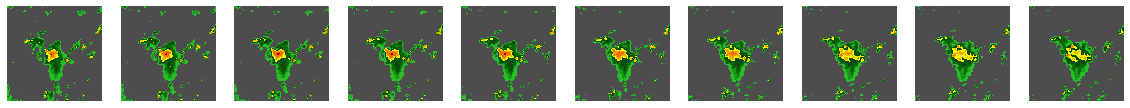

In [ ]:
img_index=0
cmap,norm,vmin,vmax=get_cmap('vil')
fig,axs=plt.subplots(1,10,figsize=(20,8))
for i in range(10):
    axs[i].imshow((ot.detach().cpu()[img_index,i,:,:]*norm_['scale']+norm_['shift']),origin='lower',cmap=cmap,norm=norm,vmin=vmin,vmax=vmax) 
    axs[i].set_axis_off()

In [ ]:
img_index=7
cmap,norm,vmin,vmax=get_cmap('vil')
fig,axs=plt.subplots(1,10,figsize=(20,8))
for i in range(10):
    axs[i].imshow((train_data.detach().cpu()[img_index,i+13,:,:]*norm_['scale']+norm_['shift']),origin='lower',cmap=cmap,norm=norm,vmin=vmin,vmax=vmax) 
    axs[i].set_axis_off()

In [ ]:
ot = u_net_model(train_data[7,:13,:,:][None,:,:,:].to(device))

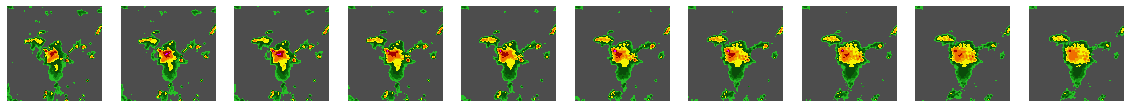

In [ ]:
img_index=0
cmap,norm,vmin,vmax=get_cmap('vil')
fig,axs=plt.subplots(1,10,figsize=(20,8))
for i in range(10):
    axs[i].imshow((ot.detach().cpu()[img_index,i,:,:]*norm_['scale']+norm_['shift']),origin='lower',cmap=cmap,norm=norm,vmin=vmin,vmax=vmax) 
    axs[i].set_axis_off()

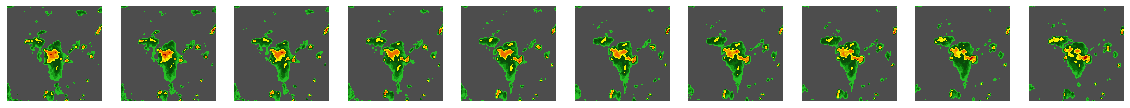

In [ ]:
img_index=7
cmap,norm,vmin,vmax=get_cmap('vil')
fig,axs=plt.subplots(1,10,figsize=(20,8))
for i in range(10):
    axs[i].imshow((train_data.detach().cpu()[img_index,i+13,:,:]*norm_['scale']+norm_['shift']),origin='lower',cmap=cmap,norm=norm,vmin=vmin,vmax=vmax) 
    axs[i].set_axis_off()

In [ ]:
ot = u_net_model(val_data[0,:13,:,:][None,:,:,:].to(device))

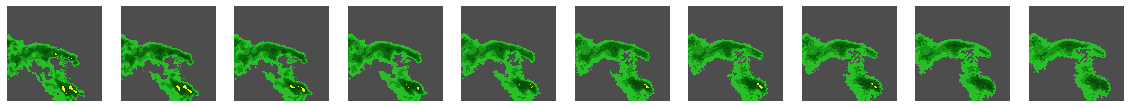

In [ ]:
img_index=0
cmap,norm,vmin,vmax=get_cmap('vil')
fig,axs=plt.subplots(1,10,figsize=(20,8))
for i in range(10):
    axs[i].imshow((ot.detach().cpu()[img_index,i,:,:]*norm_['scale']+norm_['shift']),origin='lower',cmap=cmap,norm=norm,vmin=vmin,vmax=vmax) 
    axs[i].set_axis_off()

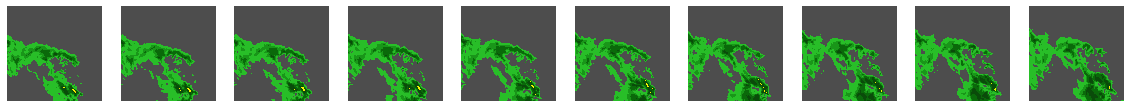

In [ ]:

img_index=0
cmap,norm,vmin,vmax=get_cmap('vil')
fig,axs=plt.subplots(1,10,figsize=(20,8))
for i in range(10):
    axs[i].imshow((val_data.detach().cpu()[img_index,i+13,:,:]*norm_['scale']+norm_['shift']),origin='lower',cmap=cmap,norm=norm,vmin=vmin,vmax=vmax) 
    axs[i].set_axis_off()

In [ ]:
torch.save(u_net_model.state_dict(), 'u_net1.pt') ; 

In [ ]:
check = SmaAt_UNet(n_channels=13 , n_classes=12) ;
check = check.to(device) ; 

In [ ]:
check.load_state_dict(torch.load('u_net_alpha_0.5.pt')) ; 

In [ ]:
ot = check(train_data[7,:13,:,:][None,:,:,:].to(device))

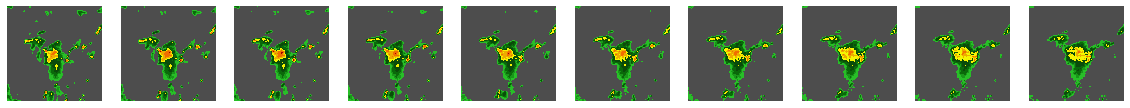

In [ ]:
img_index=0
cmap,norm,vmin,vmax=get_cmap('vil')
fig,axs=plt.subplots(1,10,figsize=(20,8))
for i in range(10):
    axs[i].imshow((ot.detach().cpu()[img_index,i,:,:]*norm_['scale']+norm_['shift']),origin='lower',cmap=cmap,norm=norm,vmin=vmin,vmax=vmax) 
    axs[i].set_axis_off()

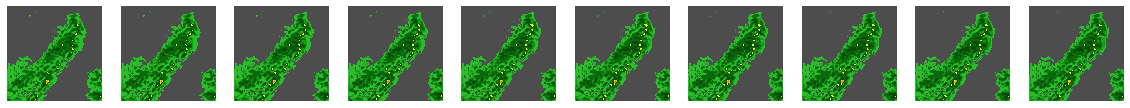

In [ ]:
img_index=0
cmap,norm,vmin,vmax=get_cmap('vil')
fig,axs=plt.subplots(1,10,figsize=(20,8))
for i in range(10):
    axs[i].imshow(ot.detach().cpu()[img_index,i,:,:],origin='lower',cmap=cmap,norm=norm,vmin=vmin,vmax=vmax) 
    axs[i].set_axis_off()

## Define Evaluation functions and Metrics


In [ ]:
## 
# Functions for plotting results
##

norm = {'scale':47.54,'shift':33.44}
hmf_colors = np.array( [
    [82,82,82], 
    [252,141,89],
    [255,255,191],
    [145,191,219]
])/255

# Model that implements persistence forecast that just repeasts last frame of input
class persistence:
    def predict(self,x_test):
        return np.tile(x_test[:,-1:,:,:],[1,12,1,1])

def plot_hit_miss_fa(ax,y_true,y_pred,thres):       ## Takes input as numpy array
    mask = np.zeros_like(y_true)
    mask[np.logical_and(y_true>=thres,y_pred>=thres)]=4
    mask[np.logical_and(y_true>=thres,y_pred<thres)]=3
    mask[np.logical_and(y_true<thres,y_pred>=thres)]=2
    mask[np.logical_and(y_true<thres,y_pred<thres)]=1
    cmap=ListedColormap(hmf_colors)
    ax.imshow(mask,cmap=cmap)


def visualize_result(models,x_test,y_test,idx,ax,labels, thresh):
    fs=10
    cmap_dict = lambda s: {'cmap':get_cmap(s,encoded=True)[0],
                           'norm':get_cmap(s,encoded=True)[1],
                           'vmin':get_cmap(s,encoded=True)[2],
                           'vmax':get_cmap(s,encoded=True)[3]}
    for i in range(1,13,3):
        #xt = x_test[idx,i,:,:]*norm['scale']+norm['shift']
        xt = x_test[idx,i,:,:].detach().cpu() ; 
        #ax[(i-1)//3][0].imshow(xt,**cmap_dict('vil'))
        ax[(i-1)//3][0].imshow(xt,cmap=get_cmap('vil')[0])
    ax[0][0].set_title('Inputs',fontsize=fs)
    
    pers = persistence().predict(x_test[idx:idx+1])
    #pers = pers*norm['scale']+norm['shift']
    x_test = x_test[idx:idx+1]
    y_test = y_test[idx:idx+1]#*norm['scale']+norm['shift']
    y_preds=[]
    for i,m in enumerate(models):
        #yp = m.predict(x_test)        ### CHANGE THIS LINE !!!  --> See shapes of X_test, Y_test --> Might be different for different models
        yp = m(x_test.to(device)).cpu().detach().numpy() ; 
        if isinstance(yp,(list,)):
            yp=yp[0]
        y_preds.append(yp)#*norm['scale']+norm['shift'])
        #print("TESTING HERE0: ", yp.shape)
    
    for i in range(0,12,3):
        ax[i//3][2].imshow(y_test[0,i,:,:].numpy(),**cmap_dict('vil'))  ## Change this line --> CHANGED 
    ax[0][2].set_title('Target',fontsize=fs)
    
    # Plot Persistence
    for i in range(0,12,3):
        #print("TESTING HERE1: ", y_test.shape)
        #print("TESTING HERE2: ", pers.shape)
        plot_hit_miss_fa(ax[i//3][4],y_test[0,i,:,:].numpy(),pers[0,i,:,:],thresh)    ## Change this LINE --> ALSO make threshold a variable value
    ax[0][4].set_title('Persistence\nScores',fontsize=fs)
    
    for k,m in enumerate(models):
        for i in range(0,12,3):
            ax[i//3][5+2*k].imshow(y_preds[k][0,i,:,:],**cmap_dict('vil'))
            plot_hit_miss_fa(ax[i//3][5+2*k+1],y_test[0,i,:,:].numpy(),y_preds[k][0,i,:,:],thresh)  ## CHANGE THIS LINE, based on shapes of inputs and outputs

        ax[0][5+2*k].set_title(labels[k],fontsize=fs)
        ax[0][5+2*k+1].set_title(labels[k]+'\nScores',fontsize=fs)
        
    for j in range(len(ax)):
        for i in range(len(ax[j])):
            ax[j][i].xaxis.set_ticks([])
            ax[j][i].yaxis.set_ticks([])
    for i in range(4):
        ax[i][1].set_visible(False)
    for i in range(4):
        ax[i][3].set_visible(False)
    ax[0][0].set_ylabel('-45 Minutes')
    ax[1][0].set_ylabel('-30 Minutes')
    ax[2][0].set_ylabel('-15 Minutes')
    ax[3][0].set_ylabel('  0 Minutes')
    ax[0][2].set_ylabel('+15 Minutes')
    ax[1][2].set_ylabel('+30 Minutes')
    ax[2][2].set_ylabel('+45 Minutes')
    ax[3][2].set_ylabel('+60 Minutes')
    
    legend_elements = [Patch(facecolor=hmf_colors[1], edgecolor='k', label='False Alarm'),
                   Patch(facecolor=hmf_colors[2], edgecolor='k', label='Miss'),
                   Patch(facecolor=hmf_colors[3], edgecolor='k', label='Hit')]
    ax[-1][-1].legend(handles=legend_elements, loc='lower right', bbox_to_anchor= (-5.4, -.35), 
                           ncol=5, borderaxespad=0, frameon=False, fontsize='16')
    plt.subplots_adjust(hspace=0.05, wspace=0.05)

In [ ]:
## Set up testing data
X_test = test_data[:,:13,:,:] ; 
Y_test = test_data[:,13:,:,:] ; 

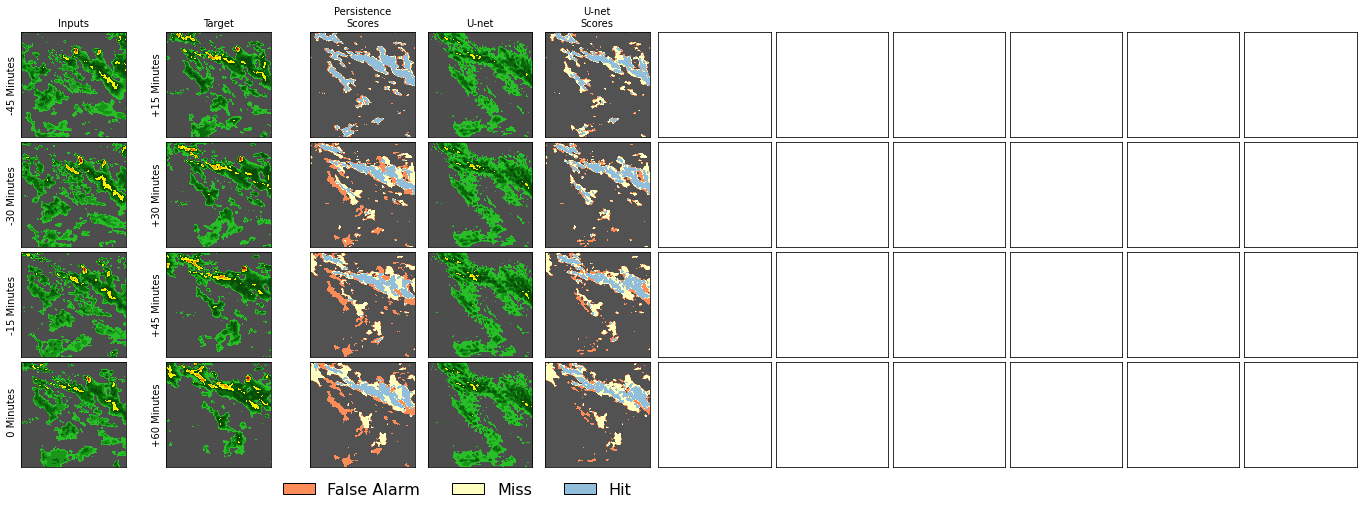

In [ ]:
idx=6 # adjust this to pick a case
fig,ax = plt.subplots(4,13,figsize=(24,8), gridspec_kw={'width_ratios': [1,.2,1,.2,1,1,1,1,1,1,1,1,1]})
visualize_result([u_net_model],X_test,Y_test,idx,ax,labels=['U-net'], thresh=74)

In [ ]:
## Y_test and Y_pred are (#samples, #frames, H,W) shaped --> Neither on GPU, but input as torch tensors
def get_eval_metrics(y_pred,y_true,thres):
  y_pred = y_pred.numpy()
  y_true = y_true.numpy()
  total_mask = np.zeros_like(y_true) ; 
  
  results_dict = {}
  results_dict['POD'] = [0] ; 
  results_dict['SUCR'] = [0] ; 
  results_dict['CSI'] = [0] ; 
  results_dict['Bias'] = [0] ; 

  for frame_num in range(y_true.shape[1]):
    for idx in range(y_true.shape[0]):

      # print("Frame number = ", frame_num)
      # print("IDX = ", idx)

      mask = np.zeros_like(y_true[0,0,:,:])
      y_pred_ = y_pred[idx,frame_num,:,:]
      y_true_ = y_true[idx,frame_num,:,:]
      mask[np.logical_and(y_true_>=thres,y_pred_>=thres)]=4
      mask[np.logical_and(y_true_>=thres,y_pred_<thres)]=3
      mask[np.logical_and(y_true_<thres,y_pred_>=thres)]=2
      mask[np.logical_and(y_true_<thres,y_pred_<thres)]=1

      total_mask[idx,frame_num,:,:] = mask 


    hits_ = np.count_nonzero(total_mask[:,frame_num,:,:]==4)
    miss_ = np.count_nonzero(total_mask[:,frame_num,:,:]==3)
    false_al_ = np.count_nonzero(total_mask[:,frame_num,:,:]==2)
    true_neg_ = np.count_nonzero(total_mask[:,frame_num,:,:]==1) 
    # print("HITS", hits_)
    # print("MISS", miss_)
    # print("FA", false_al_)
    # print("TN", true_neg_)

    #print("START", results_dict)
    results_dict['POD'].append((hits_/(hits_+miss_)))
    results_dict['SUCR'].append((hits_/(hits_+false_al_)))
    results_dict['CSI'].append((hits_/(hits_+miss_+false_al_)))
    results_dict['Bias'].append((hits_+false_al_/(hits_+miss_)))
    #print("END", results_dict)


  hits = np.count_nonzero(total_mask==4)
  miss = np.count_nonzero(total_mask==3)
  false_al = np.count_nonzero(total_mask==2)
  true_neg = np.count_nonzero(total_mask==1)

  
  results_dict['POD_total'] = hits/(hits+miss) ; 
  results_dict['SUCR_total'] = hits/(hits+false_al) ; 
  results_dict['CSI_total'] = hits/(hits+miss+false_al) ; 
  results_dict['Bias_total'] = (hits+false_al)/(hits+miss) ; 


  return total_mask, results_dict

In [ ]:
tot_mask = get_eval_metrics(Y_pred, Y_test, 100) ; 

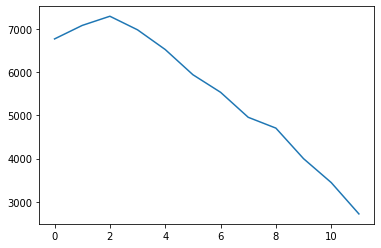

In [ ]:
plt.figure() ; 
plt.plot(tot_mask[1]['Bias'][1:])

In [ ]:
tot_mask[1]['Bias_total']

0.7388169675620138

In [ ]:
tot_mask.shape

(10, 12, 192, 192)

In [ ]:
a = []

In [ ]:
a.append(1)

In [ ]:
Y_pred.shape

torch.Size([10, 12, 192, 192])

In [ ]:
Y_pred = u_net_model(X_test.to(device)).cpu().detach() ; 

In [ ]:
def plot_hit_miss_fa(ax,y_true,y_pred,thres):       ## Takes input as numpy array
    mask = np.zeros_like(y_true)
    mask[np.logical_and(y_true>=thres,y_pred>=thres)]=4
    mask[np.logical_and(y_true>=thres,y_pred<thres)]=3
    mask[np.logical_and(y_true<thres,y_pred>=thres)]=2
    mask[np.logical_and(y_true<thres,y_pred<thres)]=1
    cmap=ListedColormap(hmf_colors)
    ax.imshow(mask,cmap=cmap)
    # plt.figure()
    # plt.imshow(mask, cmap=cmap)

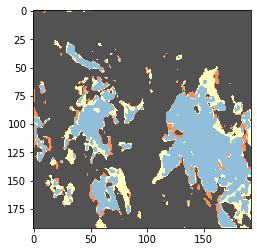

In [ ]:
plot_hit_miss_fa(0, Y_test[1,0,:,:].numpy(), Y_pred[1,0,:,:].numpy(), 74) ; 

In [ ]:
Y_test[1,0,:,:]

tensor([[26.9949, 21.0941, 12.7903,  ...,  0.0000,  0.0000,  0.0000],
        [35.1698, 22.2622, 10.6441,  ...,  0.0000,  0.0000,  0.0000],
        [34.2565, 22.1310, 11.9991,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 2.1611,  2.1495,  2.2341,  ..., 65.6199, 65.9306, 67.4106],
        [ 2.9246,  2.3416,  1.8388,  ..., 69.8402, 69.4939, 68.6069],
        [ 2.9978,  2.7888,  2.2135,  ..., 75.9820, 71.2821, 67.8042]])

In [ ]:
Y_pred.shape

torch.Size([10, 12, 192, 192])

In [ ]:
X_test.shape

torch.Size([10, 13, 192, 192])

In [ ]:
#X_test.numpy()

In [ ]:
norm = {'scale':47.54,'shift':33.44}

In [ ]:
idx = 6

TESTING HERE0:  (1, 12, 192, 192)
TESTING HERE1:  torch.Size([1, 12, 192, 192])
TESTING HERE2:  (1, 12, 192, 192)
TESTING HERE1:  torch.Size([1, 12, 192, 192])
TESTING HERE2:  (1, 12, 192, 192)
TESTING HERE1:  torch.Size([1, 12, 192, 192])
TESTING HERE2:  (1, 12, 192, 192)
TESTING HERE1:  torch.Size([1, 12, 192, 192])
TESTING HERE2:  (1, 12, 192, 192)


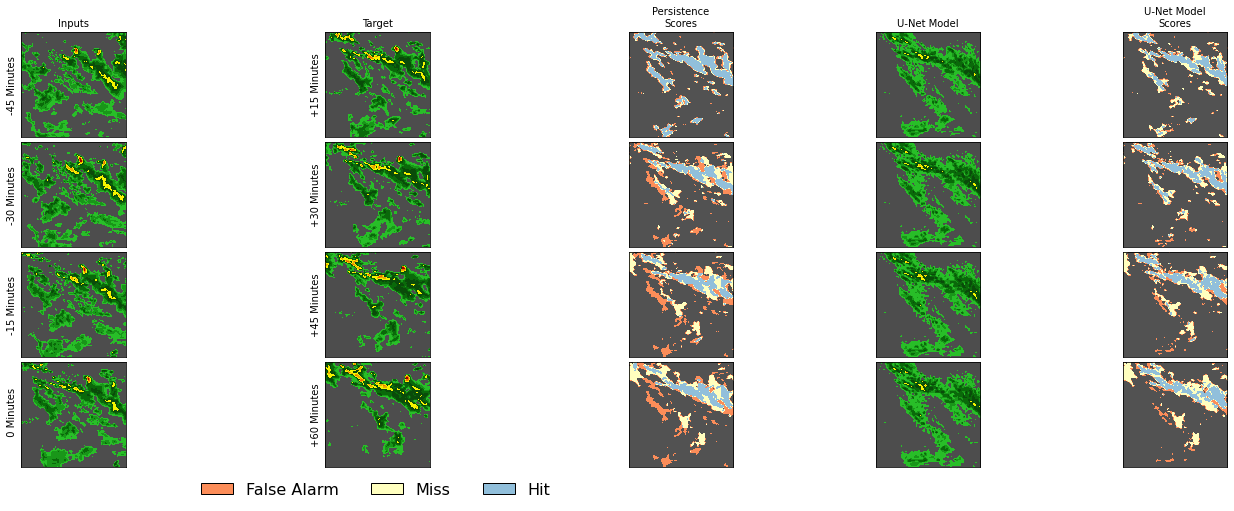

In [ ]:
fig,ax = plt.subplots(4,7,figsize=(24,8), gridspec_kw={'width_ratios': [1,.2,1,.2,1,1,1]})

fs=10
cmap_dict = lambda s: {'cmap':get_cmap(s,encoded=True)[0],
                        'norm':get_cmap(s,encoded=True)[1],
                        'vmin':get_cmap(s,encoded=True)[2],
                        'vmax':get_cmap(s,encoded=True)[3]}
for i in range(1,13,3):
    #xt = X_test[idx,i,:,:]*norm['scale']+norm['shift']
    xt = X_test[idx,i,:,:].detach().cpu()
    #ax[(i-1)//3][0].imshow(xt,**cmap_dict('vil'))
    ax[(i-1)//3][0].imshow(xt,cmap=get_cmap('vil')[0])
ax[0][0].set_title('Inputs',fontsize=fs)

pers = persistence().predict(X_test[idx:idx+1].numpy())     ## THIS LINE CHANGED
#pers = pers*norm['scale']+norm['shift']
x_test = X_test[idx:idx+1]
y_test = Y_test[idx:idx+1]#*norm['scale']+norm['shift']
y_preds=[]

models = [u_net_model] ; 

for i,m in enumerate(models):
        #yp = m.predict(x_test)        ### CHANGE THIS LINE !!!  --> See shapes of X_test, Y_test --> Might be different for different models
        yp = m(x_test.to(device)).cpu().detach().numpy() ; 
        if isinstance(yp,(list,)):
            yp=yp[0]
        y_preds.append(yp)#*norm['scale']+norm['shift'])
        print("TESTING HERE0: ", yp.shape)

for i in range(0,12,3):
  ax[i//3][2].imshow(y_test[0,i,:,:].numpy(),**cmap_dict('vil'))  ## Change this line --> CHANGED 
ax[0][2].set_title('Target',fontsize=fs)

# Plot Persistence
for i in range(0,12,3):
    print("TESTING HERE1: ", y_test.shape)
    print("TESTING HERE2: ", pers.shape)
    plot_hit_miss_fa(ax[i//3][4],y_test[0,i,:,:].numpy(),pers[0,i,:,:],thres=74)    ## Change this LINE --> ALSO make threshold a variable value
ax[0][4].set_title('Persistence\nScores',fontsize=fs)

labels = ['U-Net Model']

for k,m in enumerate(models):
    for i in range(0,12,3):
        ax[i//3][5+2*k].imshow(y_preds[k][0,i,:,:],**cmap_dict('vil'))
        plot_hit_miss_fa(ax[i//3][5+2*k+1],y_test[0,i,:,:].numpy(),y_preds[k][0,i,:,:],thres=74)  ## CHANGE THIS LINE, based on shapes of inputs and outputs

    ax[0][5+2*k].set_title(labels[k],fontsize=fs)
    ax[0][5+2*k+1].set_title(labels[k]+'\nScores',fontsize=fs)


for j in range(len(ax)):
    for i in range(len(ax[j])):
        ax[j][i].xaxis.set_ticks([])
        ax[j][i].yaxis.set_ticks([])
for i in range(4):
    ax[i][1].set_visible(False)
for i in range(4):
    ax[i][3].set_visible(False)
ax[0][0].set_ylabel('-45 Minutes')
ax[1][0].set_ylabel('-30 Minutes')
ax[2][0].set_ylabel('-15 Minutes')
ax[3][0].set_ylabel('  0 Minutes')
ax[0][2].set_ylabel('+15 Minutes')
ax[1][2].set_ylabel('+30 Minutes')
ax[2][2].set_ylabel('+45 Minutes')
ax[3][2].set_ylabel('+60 Minutes')

legend_elements = [Patch(facecolor=hmf_colors[1], edgecolor='k', label='False Alarm'),
                Patch(facecolor=hmf_colors[2], edgecolor='k', label='Miss'),
                Patch(facecolor=hmf_colors[3], edgecolor='k', label='Hit')]
ax[-1][-1].legend(handles=legend_elements, loc='lower right', bbox_to_anchor= (-5.4, -.35), 
                        ncol=5, borderaxespad=0, frameon=False, fontsize='16')
plt.subplots_adjust(hspace=0.05, wspace=0.05)

In [ ]:
## Set up testing data
X_test = test_data[:,:13,:,:] ; 
Y_test = test_data[:,13:,:,:] ; 

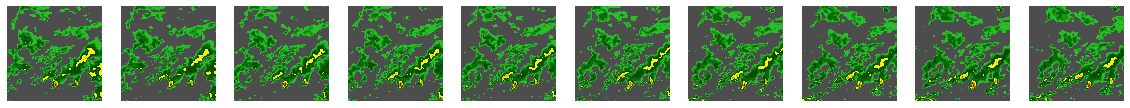

In [ ]:
img_index=6
cmap,norm,vmin,vmax=get_cmap('vil')
fig,axs=plt.subplots(1,10,figsize=(20,8))
for i in range(10):
    axs[i].imshow(X_test[img_index,i,:,:],origin='lower',cmap=cmap,norm=norm,vmin=vmin,vmax=vmax) 
    axs[i].set_axis_off()

Text(0.5, 1.0, 'Target')

TESTING HERE1:  torch.Size([1, 12, 192, 192])
TESTING HERE2:  (1, 12, 192, 192)
TESTING HERE1:  torch.Size([1, 12, 192, 192])
TESTING HERE2:  (1, 12, 192, 192)
TESTING HERE1:  torch.Size([1, 12, 192, 192])
TESTING HERE2:  (1, 12, 192, 192)
TESTING HERE1:  torch.Size([1, 12, 192, 192])
TESTING HERE2:  (1, 12, 192, 192)


Text(0.5, 1.0, 'Persistence\nScores')

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.show()